# [TIC 52368076](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC52368076TCE1)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import astropy.units as u
from glob import glob

paths = glob('52368076/*.fits')

files = [fits.getdata(path) for path in paths]

headers = [fits.getheader(path) for path in paths]

In [5]:
from scipy.stats import binned_statistic
from toolkit import LightCurve, concatenate_light_curves

lcs = [LightCurve(times=f['TIME'][~np.isnan(f["TIME"]) & ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  fluxes=f['PDCSAP_FLUX'][~np.isnan(f["TIME"])& ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  name=header['OBJECT']) for f, header in zip(files, headers)]

lc = concatenate_light_curves(lcs)

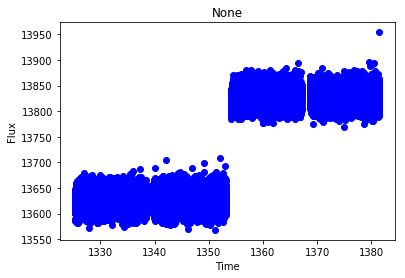

In [6]:
lc.plot()

In [10]:
from astropy.constants import G, M_sun, R_sun
import astropy.units as u

def period_to_a(params, M_star=0.93*M_sun, R_star=0.892*R_sun): 
    return (((G * M_star / (4 * np.pi**2) * (params.per * u.day)**2)**(1/3)) / R_star).decompose().value

In [14]:
from batman import TransitParams, TransitModel

paramsb = TransitParams()
paramsb.per = 4.653811
paramsb.t0 = 2458327.432906 - 2457000
paramsb.duration = 2.9/24
paramsb.rp = np.sqrt(1007.882466 * 1e-6)
paramsb.a  = period_to_a(paramsb)
paramsb.u = [0.5971, 0.1172]
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.inc = 90
paramsb.ecc = 0

paramsc = TransitParams()
paramsc.per = 9.150607
paramsc.inc = 90
paramsc.t0 = 2458334.45669 - 2457000
paramsc.duration = 2.9/24
paramsc.rp = np.sqrt(996.181819 * 1e-6)
paramsc.a = period_to_a(paramsc)
paramsc.u = [0.5971, 0.1172]
paramsc.limb_dark = 'quadratic'
paramsc.w = 90
paramsc.ecc = 0

In [15]:
# Skip partial transits
transitsb = LightCurve(**lc.mask_out_of_transit(paramsb, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsb)[:-1]
transitsc = LightCurve(**lc.mask_out_of_transit(paramsc, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsc)[1:]

In [18]:
import emcee
from copy import deepcopy
from corner import corner
import celerite
from celerite import terms, modeling

Initial log likelihood: -1688.685002601269


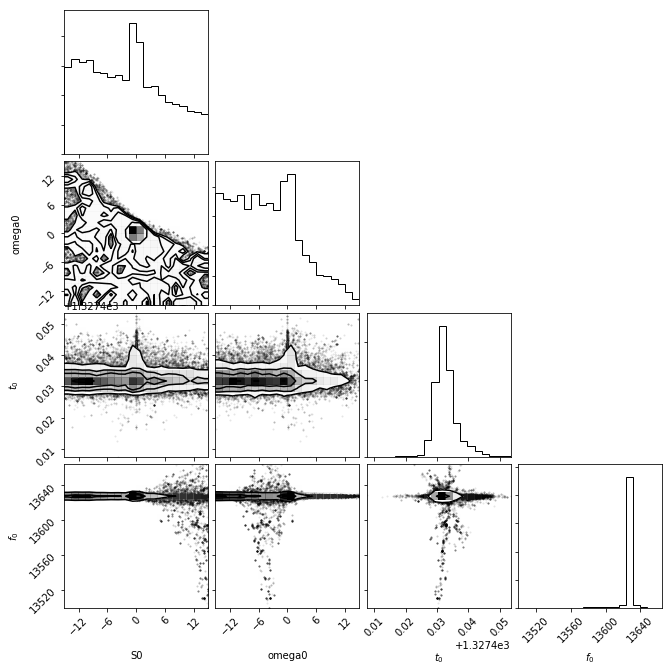

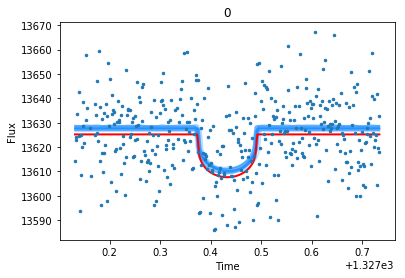

Initial log likelihood: -1692.1128473855758


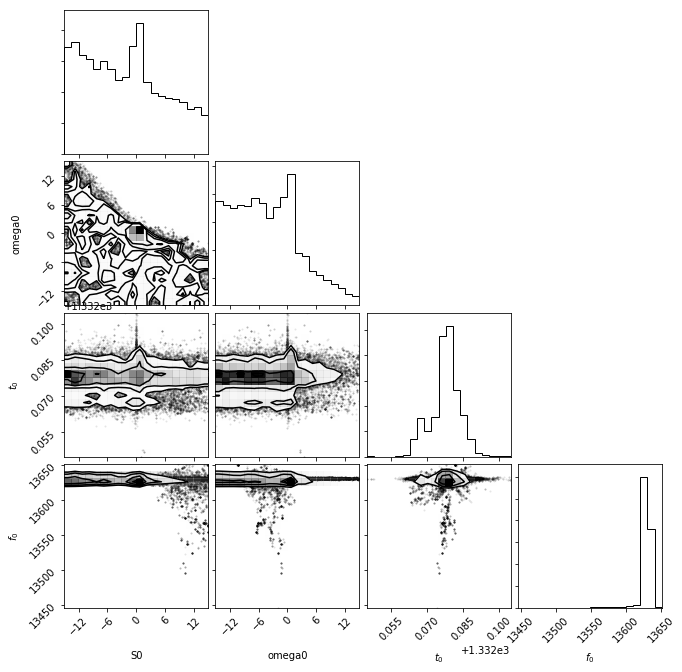

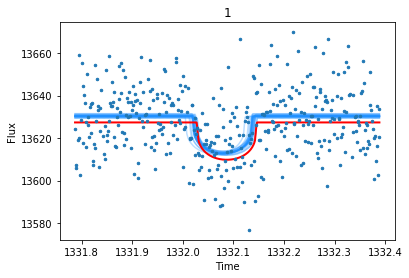

Initial log likelihood: -1770.230354347888


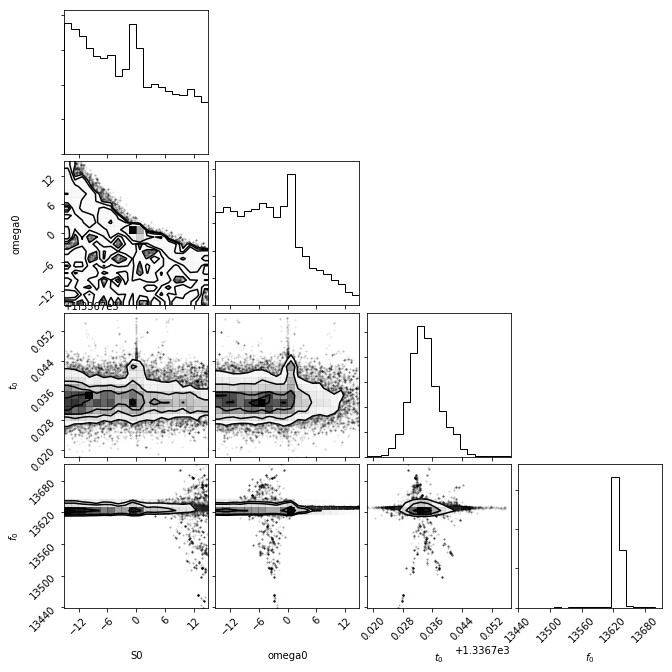

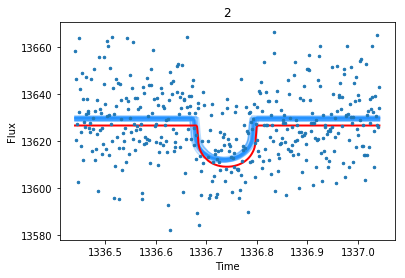

Initial log likelihood: -1773.7574471706596


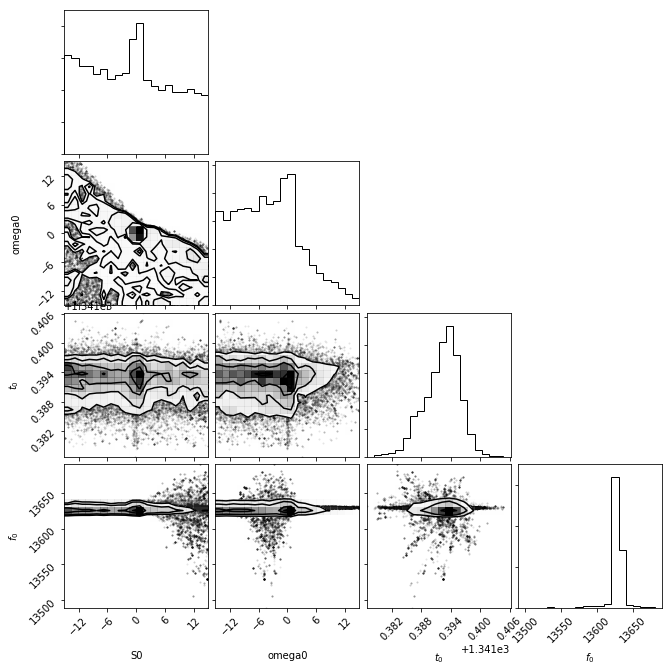

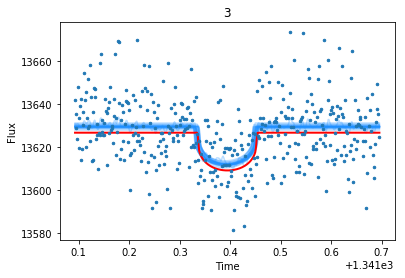

Initial log likelihood: -1782.3475677661713


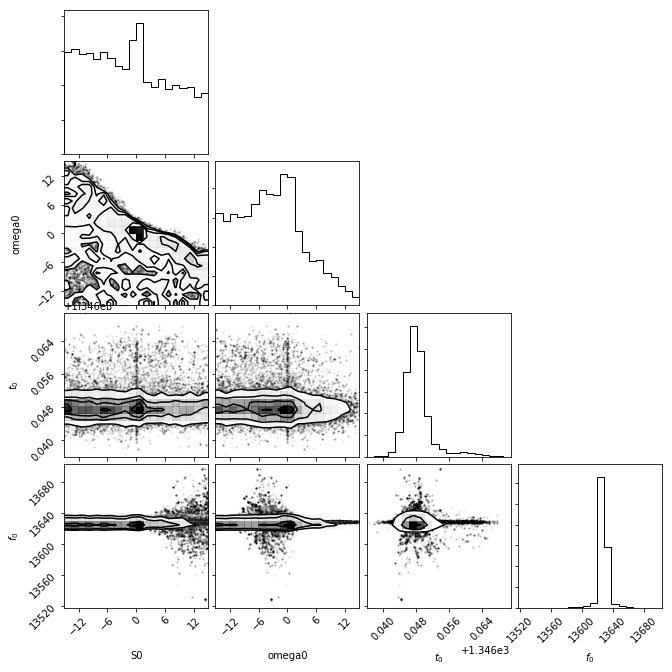

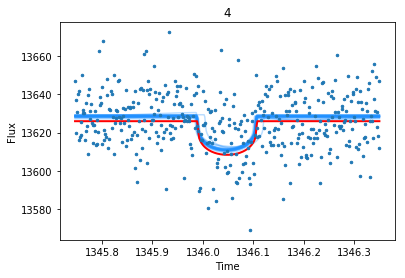

Initial log likelihood: -1794.4232539630136


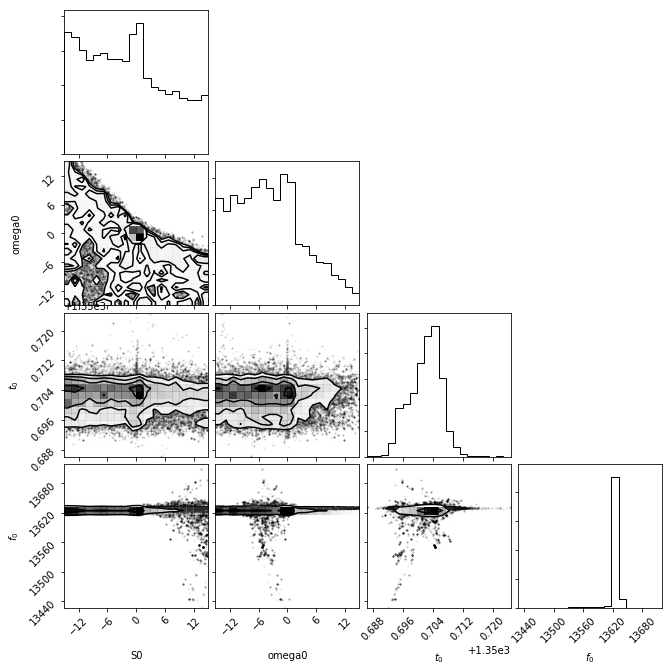

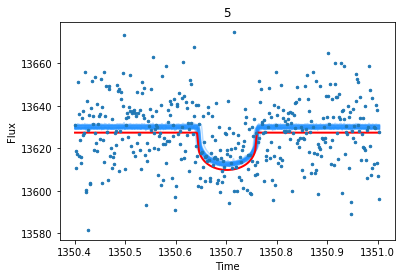

Initial log likelihood: -1751.4182242603538


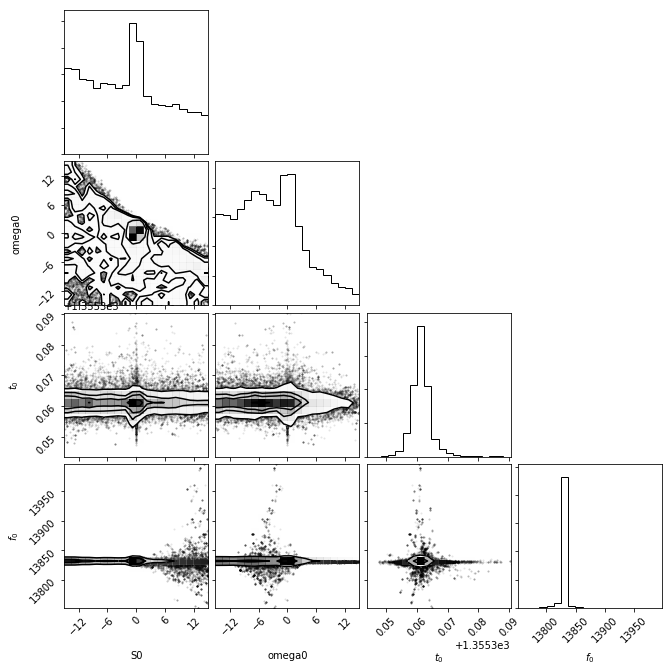

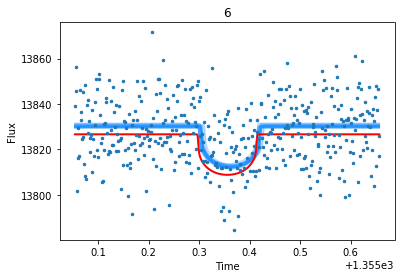

Initial log likelihood: -1795.271774249837


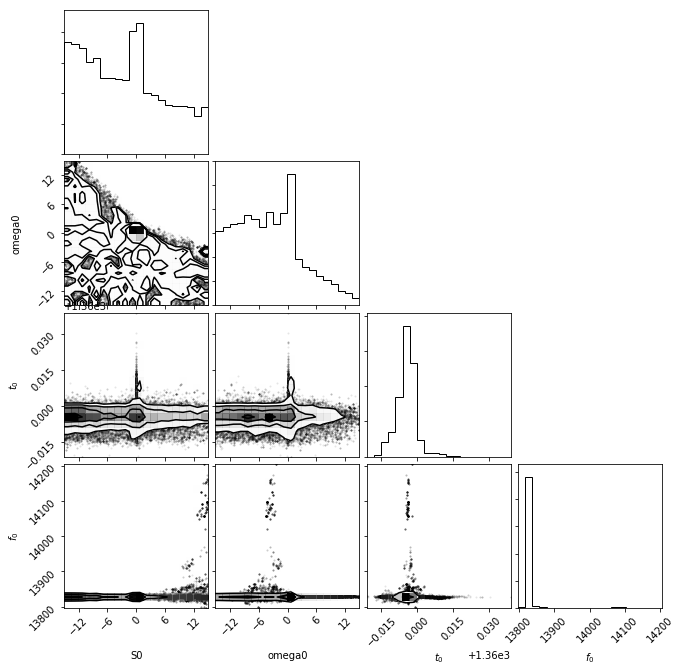

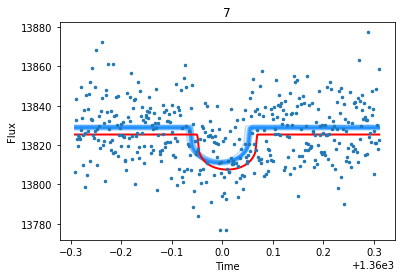

Initial log likelihood: -1772.7032567273525


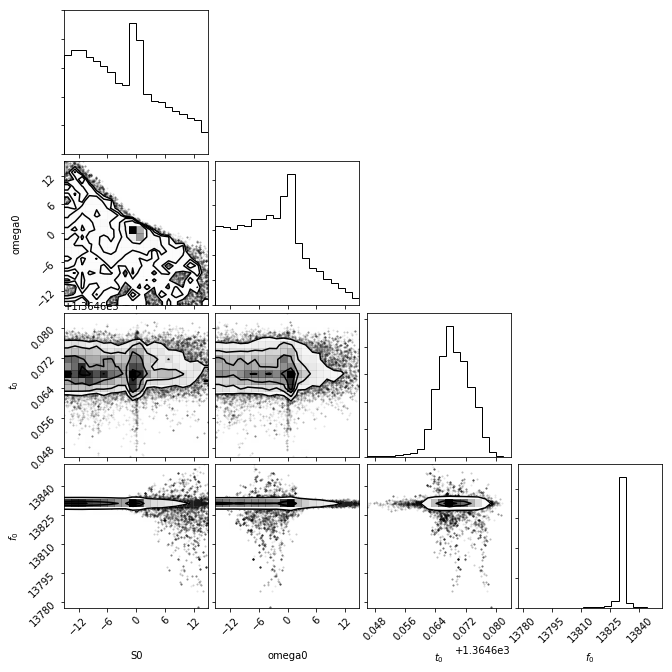

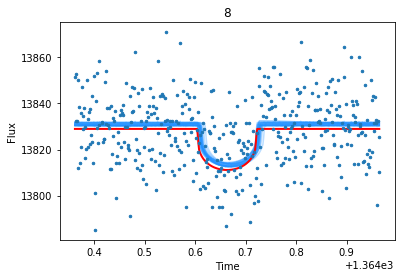

Initial log likelihood: -1777.491441656433


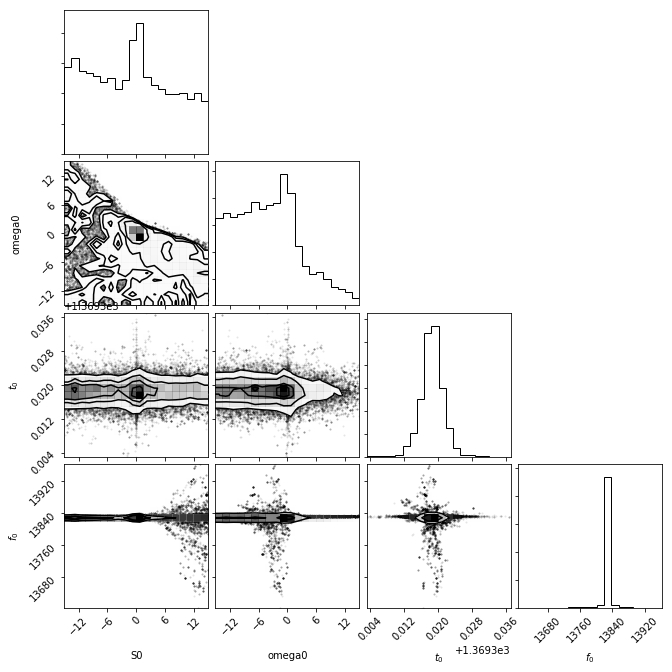

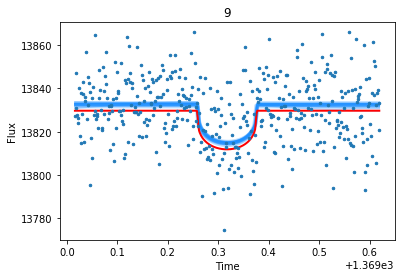

Initial log likelihood: -1760.8673010184598


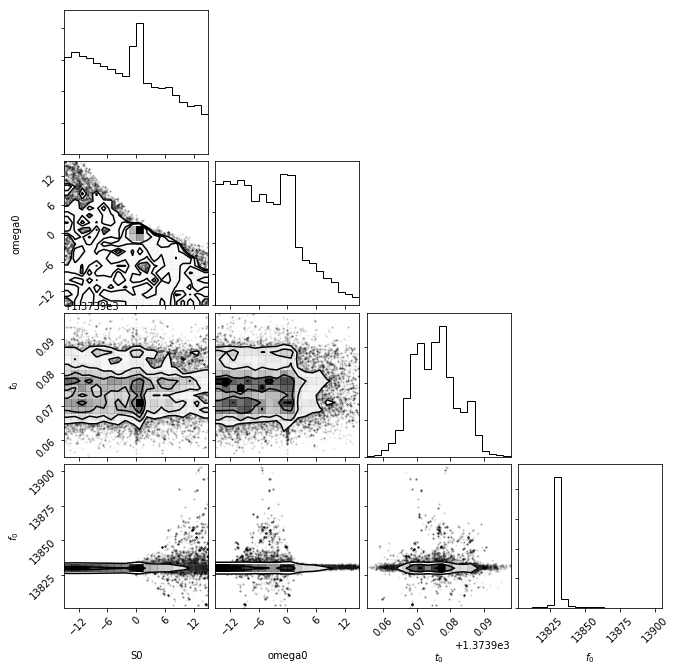

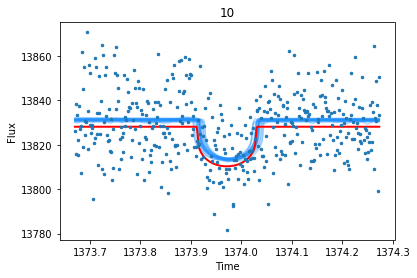

In [19]:
transit_times_b = []


class MeanModel(modeling.Model):
    parameter_names = ("t0", "f0")

    def get_value(self, t):
        params = deepcopy(paramsb)
        params.t0 = self.t0
        m = TransitModel(params, t)
        model = self.f0*m.light_curve(params) 
        return model


for transit in transitsb:    
    x, y, yerr = transit.times.jd, transit.fluxes, np.std(transit.fluxes)
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

    mean_model = MeanModel(t0=np.mean(x), f0=np.median(y))
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(x, yerr)  # You always need to call compute once.
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp) or params[2] < transit.times.jd.min() or params[2] > transit.times.jd.max():
            return -np.inf
        return gp.log_likelihood(y) + lp
    
    ndim, nwalkers = 4, 50
    
    initp = [np.array([0, 0, transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.concatenate([1e-3 * np.random.randn(3), [1*np.random.randn()]]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    sampler.run_mcmc(initp, 10000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["S0", "omega0", "$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_b.append([np.median(sampler.flatchain[:, 2]), 
                            np.std(sampler.flatchain[:, 2])])

    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsb)

    for s in sampler.flatchain[np.random.randint(sampler.flatchain.shape[0], size=24)]:
        gp.set_parameter_vector(s)
        mu = gp.predict(y, x, return_cov=False)
        plt.plot(x, mu, color='DodgerBlue', alpha=0.3)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
        
    plt.show()

    sampler.pool.close()

Initial log likelihood: -1728.881512861181


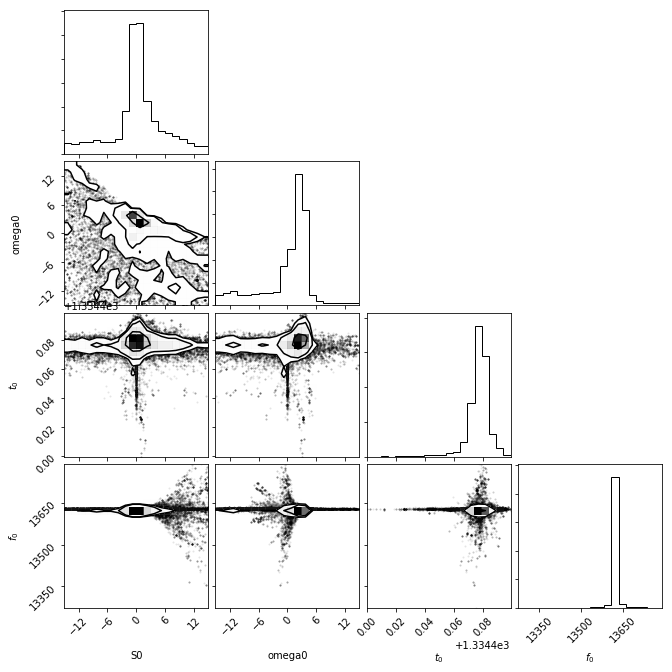

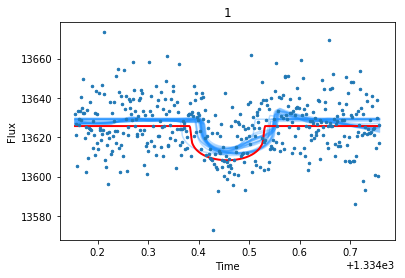

Initial log likelihood: -1775.419571852116


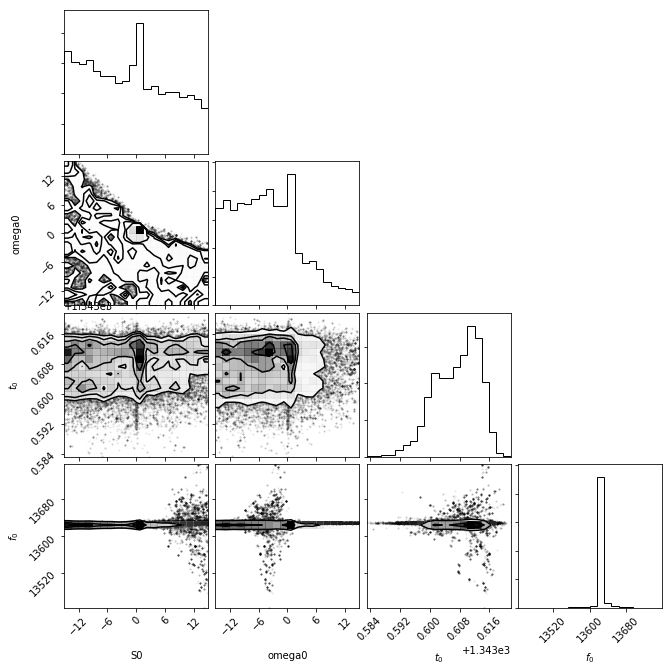

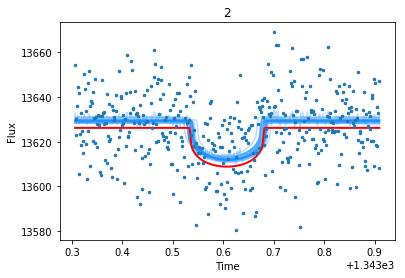

Initial log likelihood: -1794.1872491063123


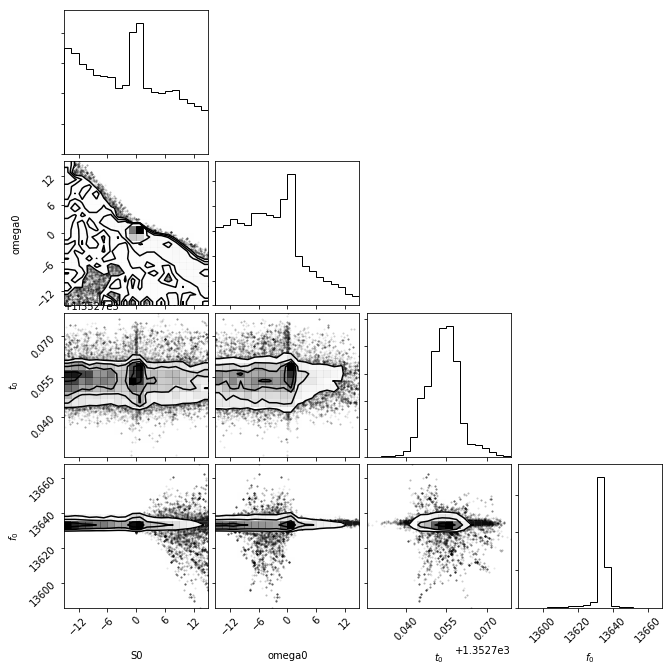

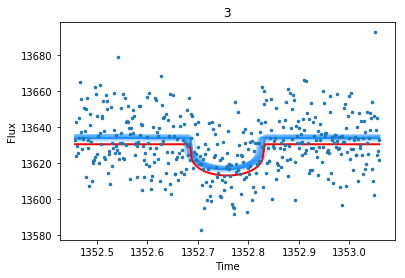

Initial log likelihood: -1736.129897308247


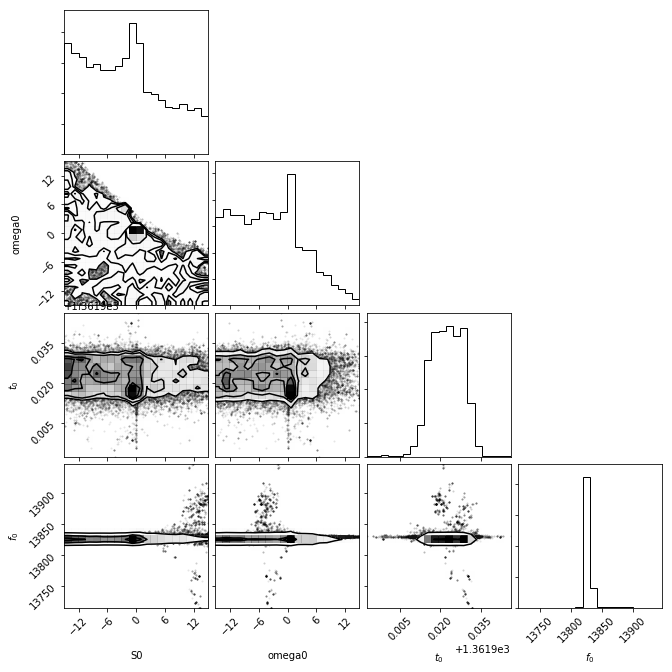

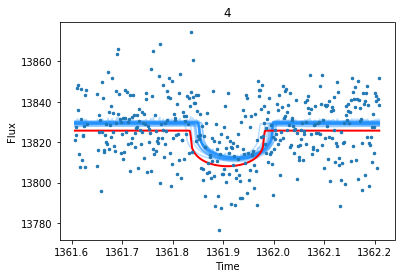

Initial log likelihood: -1729.8450628356716


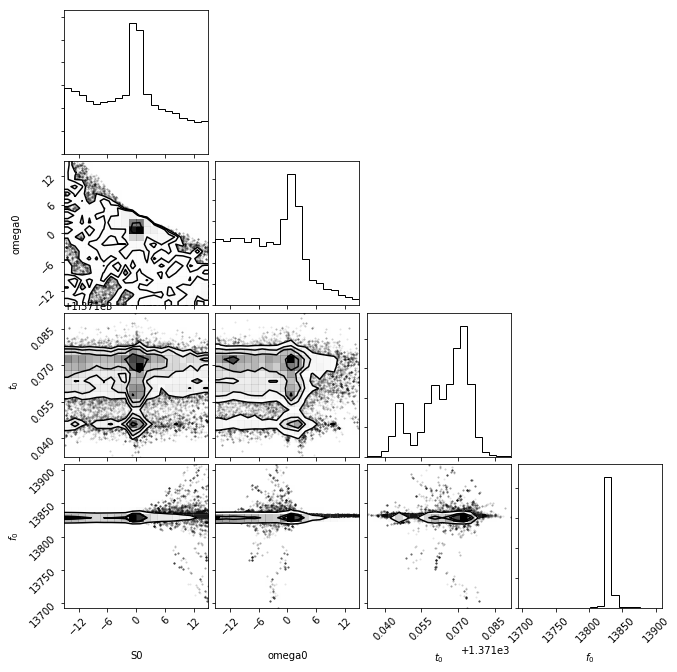

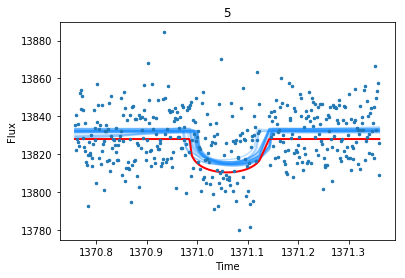

Initial log likelihood: -1741.5804128629


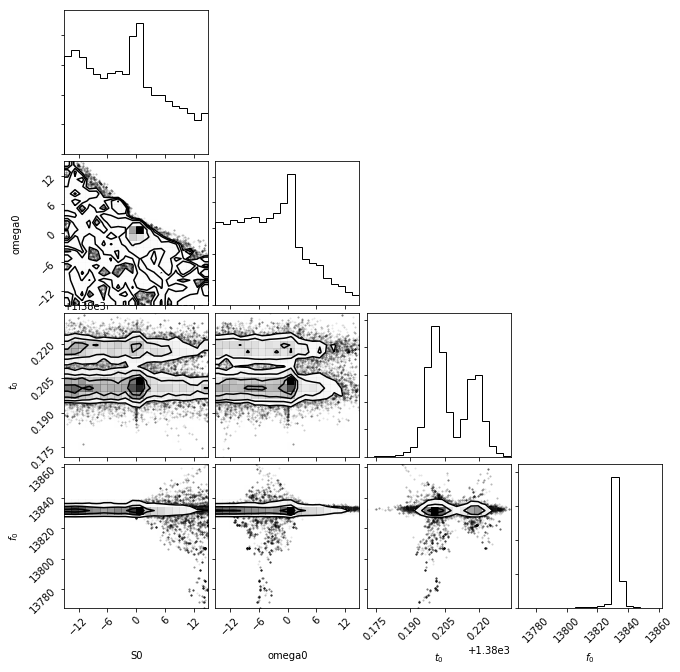

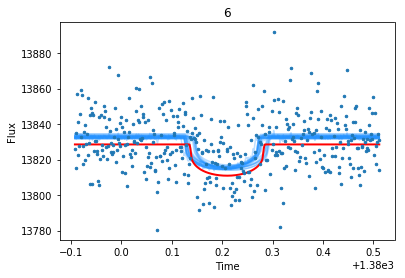

In [20]:
np.save('307210830/transit_times_b.npy', np.vstack(transit_times_b).T)
np.save('52368076//transit_times_c.npy', np.vstack(transit_times_c).T)
np.save('307210830/transit_times_d.npy', np.vstack(transit_times_d).T)

Text(0,0.5,'O-C [min]')

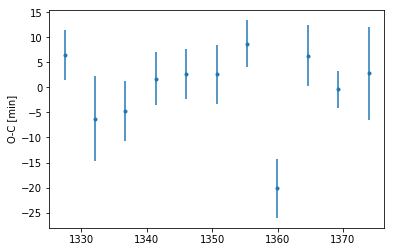

In [22]:
btimes = np.array(transit_times_b)[:, 0]
berrs = np.array(transit_times_b)[:, 1]

bepoch = np.arange(len(transit_times_b)) #[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
fit = np.polyval(np.polyfit(bepoch, btimes, 1), bepoch)

plt.errorbar(btimes, 24 * 60 * (btimes-fit), 24 * 60 * berrs, fmt='.')
#plt.ylim([-30, 30])
plt.ylabel('O-C [min]')

Text(0,0.5,'O-C [min]')

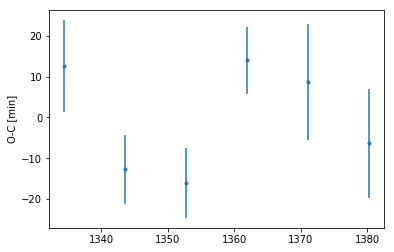

In [23]:
ctimes = np.array(transit_times_c)[:, 0]
cerrs = np.array(transit_times_c)[:, 1]

cepoch = np.arange(len(transit_times_c))#[0, 1, 3, 4, 5]
fit = np.polyval(np.polyfit(cepoch, ctimes, 1), cepoch)

plt.errorbar(ctimes, 24*60*(ctimes-fit), 24*60*cerrs, fmt='.')
plt.ylabel('O-C [min]')

In [24]:
np.save('52368076/transit_times_b.npy', np.vstack(transit_times_b).T)
np.save('52368076/transit_times_c.npy', np.vstack(transit_times_c).T)